In [1]:
import timeit

import matplotlib.pyplot as plt
from jax import jit, grad, vmap
from jax import numpy as jnp
from jax.scipy.optimize import minimize
from jax import value_and_grad

#import scipy
#from scipy.integrate import solve_ivp
import numpy as np
from jax.scipy.linalg import expm
from scipy.signal import gaussian

from qiskit.quantum_info.operators import Operator
from qiskit_ode import dispatch, solve_lmde, solve_ode
from qiskit_ode.dispatch import Array
from qiskit_ode.models import HamiltonianModel
from qiskit_ode.signals import Signal, DiscreteSignal

###############
# needed these:
from jax.config import config
config.update("jax_enable_x64", True)
dispatch.set_default_backend('jax')
###############

from qiskit_ode_internal.perturbation import solve_lmde_perturbation
from discrete_signals import get_param_to_signal
from objectives import get_grape_fidelity_func

Z = Array([[1., 0.], [0., -1.]], dtype=complex)
X = Array([[0., 1.], [1., 0.]], dtype=complex)
Y = Array([[0., -1j], [1j, 0.]], dtype=complex)

tol = 1e-8

# Approximate fidelity with Magnus terms, in the presence of 2 perturbations

Here we set up a duffing oscillator model in the rotating frame of an on-resonance drive frequency, after the RWA:
\begin{equation}
    H(t) = 2\pi\delta_0 a^\dagger a+\pi \alpha a^\dagger a (a^\dagger a - 1) + 2 \pi r(1+\delta_1)[ c_x(t) (a + a^\dagger) + c_y(t) i(a - a^\dagger)].
\end{equation}
where
- $\delta_0$ is the difference between the qubit frequency and drive frequency
-$\delta_1$ is similar to a variation in transfer function
- $\alpha$ is the anharmonicity
- $r$ is the drive strength, and
- $c_x(t)$ and $c_y(t)$ are the x and y control fields

In [2]:
#setting

dim = 4 # dimension cutoff for oscillators

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)


# model parameters - work in units of GHz/ns
anharm = -0.33
drive_strength = 0.02

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb = Array(-1j*2*np.pi*numb)

Utarget = X

Alist = -1j * Hc
D = -1j * H0

dt_filter = 0.125
T = 28.125

#get fidelity function
fid_func = get_grape_fidelity_func(X)

## Choose a signal from the 3 cells below
The signals are all in the legendre basis

In [3]:
#use hardcoded signal with good robustness against the first perturbation
param = jnp.array([[-4.59237981e+00, 4.24980538e+01, -8.46739534e+01, 5.75898575e+01,-1.50812797e-01],
                  [5.81268528e+02, 1.81435728e+02, -5.81151908e+02, -6.48605967e+01,5.10149009e+02]])

In [4]:
#or, use hardcoded signal, randomly generated
param = jnp.array([[0.42143394, 0.56289994, 0.18579787, 0.46135739, 0.00488543],
                  [0.37749316, 0.87822718, 0.18513398, 0.20995738, 0.47369254]])

In [5]:
#or, randomly generate your own signal
param = jnp.array(np.random.rand(2,5))

In [6]:
#Convert the signal from legendre basis to time series

#get the filter
param_to_signal = get_param_to_signal(4, 25)
#get the signal
signal = param_to_signal(param)
signal1 = signal[:,0]
signal2 = signal[:,1]

pc1 = DiscreteSignal(dt=dt_filter, samples=signal1,carrier_freq=0.)
pc2 = DiscreteSignal(dt=dt_filter, samples=signal2,carrier_freq=0.)
operators1 = [H0, Hc[0], Hc[1], 1j*perturb]
hamiltonian1 = HamiltonianModel(operators=Array(operators1))

def G(t):#the generator
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

#the 1st perturbation
def A0(t):
    return perturb

# the 2nd perturbation - transfer function variation
def A1(t):
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(c1*Hc[0] + c2*Hc[1])

In [7]:
#use the "generator" as input
results = solve_lmde_perturbation(A_list=[A0, A1], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=1e-13, # standard solver arguments
                             atol=1e-13)

In [8]:
U = results.y[-1] #unitary tranformation when there's no error
#symmetric Magnus terms
M0 = results.perturbation_results[[0]][-1]
M1 = results.perturbation_results[[1]][-1]
M00 = results.perturbation_results[[0, 0]][-1]
M11 = results.perturbation_results[[1, 1]][-1]
M01 = results.perturbation_results[[0, 1]][-1]
M000 = results.perturbation_results[[0, 0, 0]][-1]
M001 = results.perturbation_results[[0, 0, 1]][-1]
M011 = results.perturbation_results[[0, 1, 1]][-1]
M111 = results.perturbation_results[[1, 1, 1]][-1]
M0000 = results.perturbation_results[[0, 0, 0, 0]][-1]
M0001 = results.perturbation_results[[0, 0, 0, 1]][-1]
M0011 = results.perturbation_results[[0, 0, 1, 1]][-1]
M0111 = results.perturbation_results[[0, 1, 1, 1]][-1]
M1111 = results.perturbation_results[[1, 1, 1, 1]][-1]
M00000 = results.perturbation_results[[0, 0, 0, 0, 0]][-1]
M00001 = results.perturbation_results[[0, 0, 0, 0, 1]][-1]
M00011 = results.perturbation_results[[0, 0, 0, 1, 1]][-1]
M00111 = results.perturbation_results[[0, 0, 1, 1, 1]][-1]
M01111 = results.perturbation_results[[0, 1, 1, 1, 1]][-1]
M11111 = results.perturbation_results[[1, 1, 1, 1, 1]][-1]

In [9]:
# get the 2nd to 5th order approximate error rates using the Magnus terms
def err_est(c1, c2, order):
    #2nd order approximation
    if order == 2:
        U_approx = U@expm(c1*M0+c2*M1+c1*c2*M01+c1**2*M00+c2**2*M11)
    #3rd order approximation
    elif order == 3:
        U_approx = U@expm(c1*M0+c2*M1+c1*c2*M01+c1**2*M00+c2**2*M11
                          +c1**3*M000+c2**3*M111+c1**2*c2*M001+c1*c2**2*M011)
    elif order == 4:
        c11 = c1 * c1
        c12 = c1 * c2
        c22 = c2 * c2
        c111 = c1 * c11
        c112 = c1 * c12
        c122 = c1 * c22
        c222 = c2 * c22
        c1111 = c1 * c111
        c1112 = c1 * c112
        c1122 = c1 * c122
        c1222 = c1 * c222
        c2222 = c2 * c222
        U_approx = U@expm(c1*M0 + c2*M1 
                          + c12*M01 + c11*M00 + c22*M11
                          +c111*M000+c222*M111+c112*M001+c122*M011
                          + c1111 * M0000 + c1112 * M0001 + c1122 * M0011 + c1222 * M0111 + c2222 * M1111)
    
    elif order == 5:
        c11 = c1 * c1
        c12 = c1 * c2
        c22 = c2 * c2
        c111 = c1 * c11
        c112 = c1 * c12
        c122 = c1 * c22
        c222 = c2 * c22
        c1111 = c1 * c111
        c1112 = c1 * c112
        c1122 = c1 * c122
        c1222 = c1 * c222
        c2222 = c2 * c222
        c11111 = c1 * c1111
        c11112 = c1 * c1112
        c11122 = c1 * c1122
        c11222 = c1 * c1222
        c12222 = c1 * c2222
        c22222 = c2 * c2222
        U_approx = U@expm(c1*M0 + c2*M1 
                          + c12*M01 + c11*M00 + c22*M11
                          +c111*M000+c222*M111+c112*M001+c122*M011
                          + c1111 * M0000 + c1112 * M0001 + c1122 * M0011 + c1222 * M0111 + c2222 * M1111
                         + c11111 * M00000 + c11112 * M00001 + c11122 * M00011 + c11222 * M00111 + c12222 * M01111 + c22222 * M11111)
        
    fid = fid_func(U_approx)
    return 1. - fid 

z_vals = jnp.linspace(-1.5*drive_strength, 1.5*drive_strength, 10)
v_vals = jnp.linspace(-0.2, 0.2, len(z_vals))
err_estimate2 = [err_est(z,v,2) for v in v_vals for z in z_vals]
err_estimate3 = [err_est(z,v,3) for v in v_vals for z in z_vals]
err_estimate4 = [err_est(z,v,4) for v in v_vals for z in z_vals]
err_estimate5 = [err_est(z,v,5) for v in v_vals for z in z_vals]

In [10]:
#exact error with the two perturbations
def exact_err(args):
    c1,c2 = args
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal1,carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal2,carrier_freq=0.)
    signals2 = [1., pc1_, pc2_, Array(c1)]
    ham_copy = hamiltonian1.copy()
    ham_copy.signals = signals2
    time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
    return 1.-fid_func(time_results.y[-1]).data

err_exact = vmap(exact_err)((jnp.tile(z_vals,len(v_vals)),jnp.repeat(v_vals,len(z_vals))))

<ipython-input-11-ac0d31d0e8f4>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax0.pcolormesh(z_vals, v_vals, err_exact.reshape(len(z_vals),len(v_vals)))
<ipython-input-11-ac0d31d0e8f4>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(z_vals, v_vals, jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals)))
<ipython-input-11-ac0d31d0e8f4>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C 

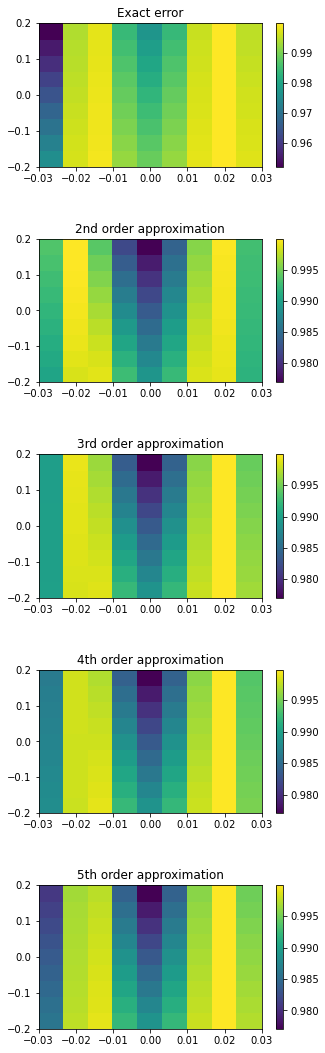

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#plot the estimates and the exact errors together
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5)
im0 = ax0.pcolormesh(z_vals, v_vals, err_exact.reshape(len(z_vals),len(v_vals)))
im1 = ax1.pcolormesh(z_vals, v_vals, jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals)))
im2 = ax2.pcolormesh(z_vals, v_vals, jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals)))
im3 = ax3.pcolormesh(z_vals, v_vals, jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals)))
im4 = ax4.pcolormesh(z_vals, v_vals, jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals)))
ax0.title.set_text('Exact error')
ax1.title.set_text('2nd order approximation')
ax2.title.set_text('3rd order approximation')
ax3.title.set_text('4th order approximation')
ax4.title.set_text('5th order approximation')
fig.colorbar(im0, ax=ax0)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
fig.set_size_inches(5, 18.5) #change these numbers to adjust the plots
plt.show()

Text(0, 0.5, 'Error')

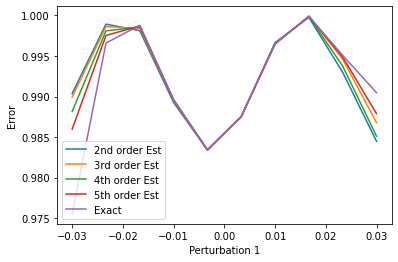

In [12]:
#Plot the diagonal of the 2D plot above
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]

plt.plot(z_vals, dia_err2,label='2nd order Est')
plt.plot(z_vals, dia_err3,label='3rd order Est')
plt.plot(z_vals, dia_err4,label='4th order Est')
plt.plot(z_vals, dia_err5,label='5th order Est')
plt.plot(z_vals, dia_err_exact,label='Exact')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

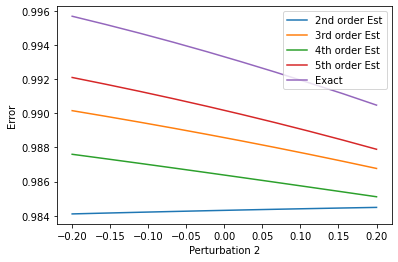

In [13]:
#Plot variation along vertical
col = 15
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]

plt.plot(v_vals, dia_err2,label='2nd order Est')
plt.plot(v_vals, dia_err3,label='3rd order Est')
plt.plot(v_vals, dia_err4,label='4th order Est')
plt.plot(v_vals, dia_err5,label='5th order Est')
plt.plot(v_vals, dia_err_exact,label='Exact')
plt.legend()
plt.xlabel('Perturbation 2')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

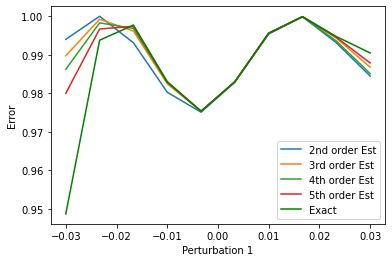

In [14]:
#Plot variation along horizontal
row = 10
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]

plt.plot(z_vals, dia_err2,label='2nd order Est')
plt.plot(z_vals, dia_err3,label='3rd order Est')
plt.plot(z_vals, dia_err4,label='4th order Est')
plt.plot(z_vals, dia_err5,label='5th order Est')
plt.plot(z_vals, dia_err_exact,color='g',label='Exact')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Error')

## Compare the costs: use an approximate fid curve v.s. the exact fid curve in objective function

In [15]:
#random inputs
inputs = jnp.array(np.random.rand(10,2,5))

#objective function defined with the approximate fid curve (2nd order)
def obj1(param1, z_vals, v_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])
    
    results = solve_lmde_perturbation(A_list=[A0, A1_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
    #symmetric Magnus terms
    M0 = results.perturbation_results[[0]][-1]
    M1 = results.perturbation_results[[1]][-1]
    M00 = results.perturbation_results[[0, 0]][-1]
    M11 = results.perturbation_results[[1, 1]][-1]
    M01 = results.perturbation_results[[0, 1]][-1]
    M000 = results.perturbation_results[[0, 0, 0]][-1]
    M001 = results.perturbation_results[[0, 0, 1]][-1]
    M011 = results.perturbation_results[[0, 1, 1]][-1]
    M111 = results.perturbation_results[[1, 1, 1]][-1]
    M0000 = results.perturbation_results[[0, 0, 0, 0]][-1]
    M0001 = results.perturbation_results[[0, 0, 0, 1]][-1]
    M0011 = results.perturbation_results[[0, 0, 1, 1]][-1]
    M0111 = results.perturbation_results[[0, 1, 1, 1]][-1]
    M1111 = results.perturbation_results[[1, 1, 1, 1]][-1]
    M00000 = results.perturbation_results[[0, 0, 0, 0, 0]][-1]
    M00001 = results.perturbation_results[[0, 0, 0, 0, 1]][-1]
    M00011 = results.perturbation_results[[0, 0, 0, 1, 1]][-1]
    M00111 = results.perturbation_results[[0, 0, 1, 1, 1]][-1]
    M01111 = results.perturbation_results[[0, 1, 1, 1, 1]][-1]
    M11111 = results.perturbation_results[[1, 1, 1, 1, 1]][-1]
    def err_est(args):
        c1, c2 = args
        c11 = c1 * c1
        c12 = c1 * c2
        c22 = c2 * c2
        c111 = c1 * c11
        c112 = c1 * c12
        c122 = c1 * c22
        c222 = c2 * c22
        c1111 = c1 * c111
        c1112 = c1 * c112
        c1122 = c1 * c122
        c1222 = c1 * c222
        c2222 = c2 * c222
        c11111 = c1 * c1111
        c11112 = c1 * c1112
        c11122 = c1 * c1122
        c11222 = c1 * c1222
        c12222 = c1 * c2222
        c22222 = c2 * c2222
        U_approx = U@expm(c1*M0 + c2*M1 
                          + c12*M01 + c11*M00 + c22*M11
                          +c111*M000+c222*M111+c112*M001+c122*M011
                          + c1111 * M0000 + c1112 * M0001 + c1122 * M0011 + c1222 * M0111 + c2222 * M1111
                         + c11111 * M00000 + c11112 * M00001 + c11122 * M00011 + c11222 * M00111 + c12222 * M01111 + c22222 * M11111)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    err_estimate = vmap(err_est)((jnp.tile(z_vals,len(v_vals)),jnp.repeat(v_vals,len(z_vals))))
    return Array(jnp.sum(err_estimate)).data

#objective function defined with the exact fid curve
def obj2(param2, z_vals, v_vals):
    sig2 = param_to_signal(param2)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig2[:,1],carrier_freq=0.)
    
    def exact_err(args):
        c1,c2 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal1,carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal2,carrier_freq=0.)
        signals2 = [1., pc1_, pc2_, Array(c1)]
        ham_copy = hamiltonian1.copy()
        ham_copy.signals = signals2
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    err_exact = vmap(exact_err)((jnp.tile(z_vals,len(v_vals)),jnp.repeat(v_vals,len(z_vals))))
    return Array(jnp.sum(err_exact)).data

In [16]:
from time import time

In [17]:
#time it takes to evaluate the approximation
obj = lambda params: obj1(params, z_vals, v_vals)


jit_obj = jit(value_and_grad(obj))

start = time()
val = jit_obj(inputs[0])[0].block_until_ready()
jit_time = time() - start

jitted_times = []
for rand_in in inputs[1:]:
    start = time()
    val = jit_obj(rand_in)[0].block_until_ready()
    jitted_times.append(time() - start)

print('Time to jit and run once: ' + str(jit_time))
print('Average jitted run time: ' + str(np.sum(jitted_times) / len(jitted_times)))
print('Average time including initial jit: ' + str((np.sum(jitted_times) + jit_time) / (len(jitted_times) + 1)))

Time to jit and run once: 32.0845832824707
Average jitted run time: 4.934258408016628
Average time including initial jit: 7.649290895462036


In [18]:
#time it takes to evaluate the exact fid curve
obj = lambda params: obj2(params, z_vals, v_vals)


jit_obj = jit(value_and_grad(obj))

start = time()
val = jit_obj(inputs[0])[0].block_until_ready()
jit_time = time() - start

jitted_times = []
for rand_in in inputs[1:]:
    start = time()
    val = jit_obj(rand_in)[0].block_until_ready()
    jitted_times.append(time() - start)

print('Time to jit and run once: ' + str(jit_time))
print('Average jitted run time: ' + str(np.sum(jitted_times) / len(jitted_times)))
print('Average time including initial jit: ' + str((np.sum(jitted_times) + jit_time) / (len(jitted_times) + 1)))

Time to jit and run once: 4.636971950531006
Average jitted run time: 2.3945191436343722
Average time including initial jit: 2.6187644243240356


## Plotting run-time increase with number of points

Here we want to provide a visual representation of the scaling cost of the gradient computation as a function of the number of points. The cost of both will scale linearly, with the rate difference coming from the difference between doing a full ODE simulation v.s. doing a single exponential.

The motivation for considering such a large number of points is not for this model, but for applications with many more uncertain parameters. E.g. a for model with $10$ uncertain parameters, even if only $3$ points along each parameter axis are used, this results in a grid of $3^{10} = 59049$ points. I'm realizing that the simulation below doesn't quite capture the scaling cost of this for the Magnus method as we would need to also compute many more Magnus terms. Should we update this? We could potentially do this "artificially" by just increasing the number of operators in the symmetric Magnus computation.

In [19]:
N_vals_sqrt = np.array(np.sqrt([10, 1e2, 1e3, 1e4, 1e5]), dtype=int)
N_vals = N_vals_sqrt ** 2

In [20]:
mag_jit_times = []
mag_ave_times = []
mag_ave_jitted_times = []

for idx, N in enumerate(N_vals_sqrt):
    print('Working on number ' + str(idx + 1) + '/' + str(len(N_vals)))
    z_vals = jnp.linspace(-1.5 * drive_strength, 1.5 * drive_strength, int(N))
    v_vals = jnp.linspace(-0.2, 0.2, len(z_vals))

    obj = lambda params: obj1(params, z_vals, v_vals)
    jit_obj = jit(value_and_grad(obj))

    # measure time to jit/grad + one evaluation
    start = time()
    val = jit_obj(inputs[0])[0].block_until_ready()
    mag_jit_times.append(time() - start)

    # average jitted run time over multiple inputs
    jitted_time = 0.
    for rand_in in inputs[1:]:
        start = time()
        val = jit_obj(rand_in)[0].block_until_ready()
        jitted_time += time() - start
    
    mag_ave_jitted_times.append(jitted_time / (len(inputs) - 1))
    mag_ave_times.append((mag_jit_times[-1] + jitted_time) / len(inputs))

Working on number 1/5
Working on number 2/5
Working on number 3/5
Working on number 4/5
Working on number 5/5


Initial results:

In [21]:
print(mag_jit_times)
print(mag_ave_times)
print(mag_ave_jitted_times)

[30.228678941726685, 33.75034284591675, 34.48591899871826, 34.30910611152649, 39.24224019050598]
[7.029416704177857, 8.041097187995911, 9.104953074455262, 10.044741201400758, 14.666435980796814]
[4.451720900005764, 5.184514337115818, 6.28484574953715, 7.348700655831231, 11.935791068606907]


In [22]:
point_jit_times = []
point_ave_times = []
point_ave_jitted_times = []

for idx, N in enumerate(N_vals_sqrt):
    print('Working on number ' + str(idx + 1) + '/' + str(len(N_vals)))
    z_vals = jnp.linspace(-1.5 * drive_strength, 1.5 * drive_strength, int(N))
    v_vals = jnp.linspace(-0.2, 0.2, len(z_vals))

    obj = lambda params: obj2(params, z_vals, v_vals)
    jit_obj = jit(value_and_grad(obj))

    # measure time to jit/grad + one evaluation
    start = time()
    val = jit_obj(inputs[0])[0].block_until_ready()
    point_jit_times.append(time() - start)

    # average jitted run time over multiple inputs
    jitted_time = 0.
    for rand_in in inputs[1:]:
        start = time()
        val = jit_obj(rand_in)[0].block_until_ready()
        jitted_time += time() - start
    
    point_ave_jitted_times.append(jitted_time / (len(inputs) - 1))
    point_ave_times.append((point_jit_times[-1] + jitted_time) / len(inputs))

Working on number 1/5
Working on number 2/5
Working on number 3/5
Working on number 4/5
Working on number 5/5


In [23]:
print(point_jit_times)
print(point_ave_times)
print(point_ave_jitted_times)

[2.645779848098755, 4.9146950244903564, 26.164633989334106, 267.00866293907166, 3024.2569847106934]
[0.4502354860305786, 2.7230324029922484, 23.890185499191283, 271.6649610757828, 3046.201462960243]
[0.2062861124674479, 2.479514333936903, 23.637469000286526, 272.18232753541736, 3048.6397383213043]


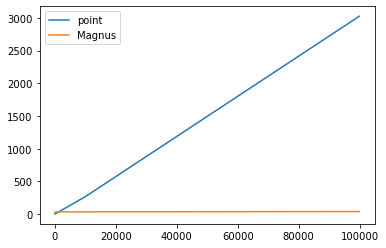

In [42]:
plt.plot(N_vals, point_jit_times, label='point')
plt.plot(N_vals, mag_jit_times, label='Magnus')
plt.legend()

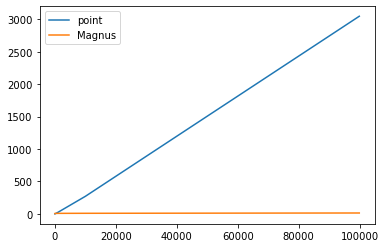

In [25]:
plt.plot(N_vals, point_ave_times, label='point')
plt.plot(N_vals, mag_ave_times, label='Magnus')
plt.legend()

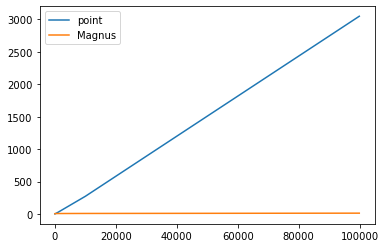

In [26]:
plt.plot(N_vals, point_ave_jitted_times, label='point')
plt.plot(N_vals, mag_ave_jitted_times, label='Magnus')
plt.legend()

Perhaps the above graphs are not the best. Of course the results are good for the Magnus-based method, but visually, going up to `1e5` points doesn't demonstrate that, at low numbers, the direct simualtion is faster, but it has a way worse scaling constant. 

Trying out Log scale for both the x and y axis:

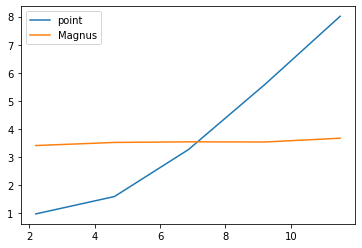

In [51]:
plt.plot(jnp.log(N_vals), jnp.log(jnp.array(point_jit_times)), label='point')
plt.plot(jnp.log(N_vals), jnp.log(jnp.array(mag_jit_times)), label='Magnus')
plt.legend()

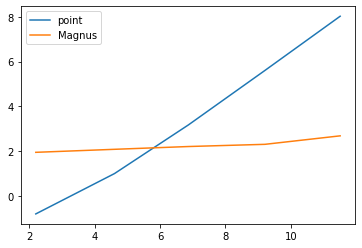

In [52]:
plt.plot(jnp.log(N_vals), jnp.log(jnp.array(point_ave_times)), label='point')
plt.plot(jnp.log(N_vals), jnp.log(jnp.array(mag_ave_times)), label='Magnus')
plt.legend()

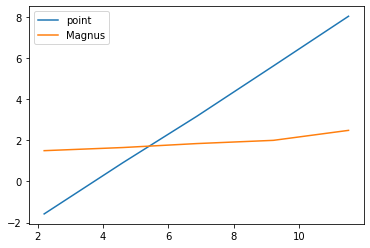

In [53]:
plt.plot(jnp.log(N_vals), jnp.log(jnp.array(point_ave_jitted_times)), label='point')
plt.plot(jnp.log(N_vals), jnp.log(jnp.array(mag_ave_jitted_times)), label='Magnus')
plt.legend()

Considering just the averaged jitted times, it seems that the time-cost of adding a new point for the Magnus-based objective is roughly:

In [34]:
(mag_ave_jitted_times[-1] - mag_ave_jitted_times[0]) / (N_vals[-1] - N_vals[0])

7.495538342264809e-05

Whereas for the full simulation based method is:

In [35]:
(point_ave_jitted_times[-1] - point_ave_jitted_times[0]) / (N_vals[-1] - N_vals[0])

0.030531047024035144

giving a difference of $2-3$ orders of magnitude (I think, essentially, the difference between computing/differentiating an exponential, v.s. computing/differentiating the solution to a DE).

Question: Is this a fair/meaningful comparison? Other points yield different results. I think in principle it should be linear, but practically it may not be (for better or worse).

In [39]:
print((mag_ave_jitted_times[-2] - mag_ave_jitted_times[0]) / (N_vals[-2] - N_vals[0]))
print((point_ave_jitted_times[-2] - point_ave_jitted_times[0]) / (N_vals[-2] - N_vals[0]))

0.0002899589386273113
0.027222104035927324


In [40]:
print((mag_ave_jitted_times[-3] - mag_ave_jitted_times[0]) / (N_vals[-3] - N_vals[0]))
print((point_ave_jitted_times[-3] - point_ave_jitted_times[0]) / (N_vals[-3] - N_vals[0]))

0.0019255513125329689
0.024612587067036847
